# Final model performance

In this notebook we run our best-performing model on the test set to get a final estimate of its performance.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from HelperFunctions import *

## Loading the data

In [2]:
df_train = pd.read_csv('./train_data.csv')
df_test = pd.read_csv('./test_data.csv')

We will now perform some imputation and scaling. It is important to note that all of the transformations we will perform here will be performed "within season," meaning that the data for a given season is transformed using information from ***only*** that season and no other.

In particular, since at the time of prediction we will have access to all of the data for that particular season, there is ***no data leakage*** occurring here.

In [3]:
df_train = ImputeAndScale(df_train)
df_test  = ImputeAndScale(df_test)

In [4]:
# select features
features = df_train.select_dtypes(include='number').columns.drop(['PLAYER_ID', 'SEASON_START', 'IN_LEAGUE_NEXT'])
print(features)

Index(['PLAYER_AGE', 'EXPERIENCE', 'GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG_PCT',
       'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
       'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS_PERCENT',
       'X3P_AR', 'F_TR', 'ORB_PERCENT', 'DRB_PERCENT', 'TRB_PERCENT',
       'AST_PERCENT', 'STL_PERCENT', 'BLK_PERCENT', 'TOV_PERCENT',
       'USG_PERCENT', 'OWS', 'DWS', 'WS', 'WS_48', 'OBPM', 'DBPM', 'BPM',
       'VORP', 'SALARY', 'WAIVED', 'RELEASED', 'TRADED', 'WAIVED_OFF',
       'WAIVED_REG', 'WAIVED_POST', 'RELEASED_OFF', 'RELEASED_REG',
       'RELEASED_POST', 'TRADED_OFF', 'TRADED_REG', 'TRADED_POST'],
      dtype='object')


## Testing model performance

### Performance metrics

We will use the following metrics in our evaluation:

* $\text{Balanced Accuracy} = \frac{\text{Recall} + \text{Specificity}}{2}$

* $\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$

* $\text{Recall} = \text{Sensitivity} = \frac{\text{TP}}{\text{TP} + \text{FN}}$

* $\text{Negative Predictive Value (NPV)} = \frac{\text{TN}}{\text{TN} + \text{FN}}$

* $\text{Specificity} = \frac{\text{TN}}{\text{TN} + \text{FP}}$

### Walk-forward testing

In order to get the most realistic estimate of our model performance, we will perform walk-forward testing. The idea is as follows:

0. **Initialize datasets**: Begin with training set `df_train` (seasons 1990-91 through 2016-17) and test set `df_test[df_test['SEASON_START']==2017]` (season 2017-18).

1. **Train the model**: Fit the model using the current training set.

2. **Evaluate performance**: Use the model to predict outcomes for the current test set and compute performance metrics.

3. **Itereate**: Expand the training set to include the current test set, replace the test set with data from the next season, and repeat from Step 1 until no future data is available.

See the following table for explicit details.

| Iteration | Training set start seasons | Test set start season |
| ---       | ---                        | ---                   |
| 1         | 1990 - 2016                | 2017                  |
| 2         | 1990 - 2017                | 2018                  |
| 3         | 1990 - 2018                | 2019                  |
| 4         | 1990 - 2019                | 2020                  |
| 5         | 1990 - 2020                | 2021                  |
| 6         | 1990 - 2021                | 2022                  |

We will write a function `test_model_performance` to implement this walk-forward testing for a given model.

### Baseline model

As a baseline model, we will consider the classifier which always predicts the majority class, which in this case is 1 (in other words it, always predicts that a player will return to the NBA the folowing year). This model should have a recall of 1 and a specificity of 0, therefore we should expect to see a balanced accuracy of 0.5.

Test Year    Bal. Acc.    Precision    Recall       NPV          Specificity 
----------------------------------------------------------------------------
2017         0.5000       0.7630       1.0000       0.0000       0.0000      0.2370      0.1830      
2018         0.5000       0.7547       1.0000       0.0000       0.0000      0.2453      0.1879      
2019         0.5000       0.8223       1.0000       0.0000       0.0000      0.1777      0.1464      
2020         0.5000       0.8333       1.0000       0.0000       0.0000      0.1667      0.1396      
2021         0.5000       0.7157       1.0000       0.0000       0.0000      0.2843      0.2118      
2022         0.5000       0.8364       1.0000       0.0000       0.0000      0.1636      0.1379      
----------------------------------------------------------------------------
Avg.         0.5000       0.7876       1.0000       0.0000       0.0000      0.2124      0.1678      


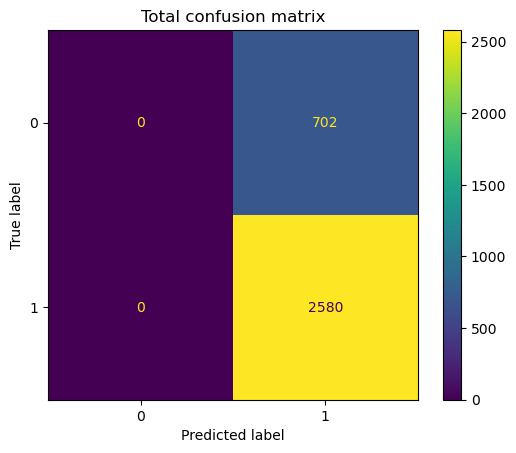

In [5]:
from sklearn.dummy import DummyClassifier

baseline_model = DummyClassifier(strategy='most_frequent')

test_model_performance(baseline_model, df_train, df_test, features)

### Final model: XGBoost with SMOTE

In `3_ModelSelection.ipynb`, we used walk-forward validation to select an XGBoost Classifier (`n_estimators=400` and `learning_rate=0.005`) together with the Synthetic Minority Oversampling Technique (SMOTE) as our final model.

Test Year    Bal. Acc.    Precision    Recall       NPV          Specificity 
----------------------------------------------------------------------------
2017         0.8032       0.9424       0.7549       0.5190       0.8516      0.1447      0.1187      
2018         0.8063       0.9280       0.8050       0.5738       0.8077      0.1419      0.1238      
2019         0.8102       0.9621       0.7586       0.4355       0.8617      0.1526      0.1086      
2020         0.7867       0.9508       0.7733       0.4138       0.8000      0.1499      0.1011      
2021         0.8488       0.9399       0.8314       0.6712       0.8663      0.1211      0.1128      
2022         0.7824       0.9545       0.7467       0.3871       0.8182      0.1634      0.1145      
----------------------------------------------------------------------------
Avg.         0.8063       0.9463       0.7783       0.5001       0.8342      0.1456      0.1132      


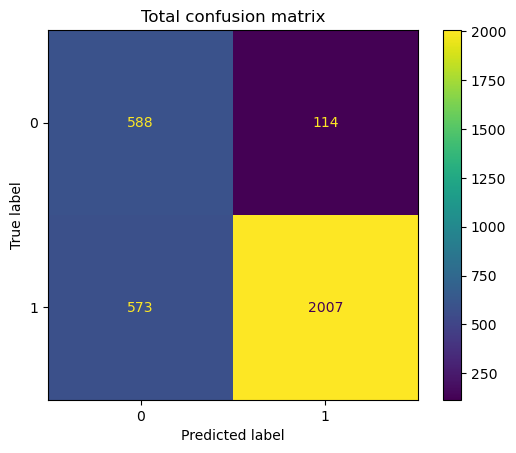

In [6]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

final_model = Pipeline([('smote', SMOTE(random_state=509)),
                        ('xgb', XGBClassifier(n_estimators=400, learning_rate=0.005, random_state=206))])

test_model_performance(final_model, df_train, df_test, features)

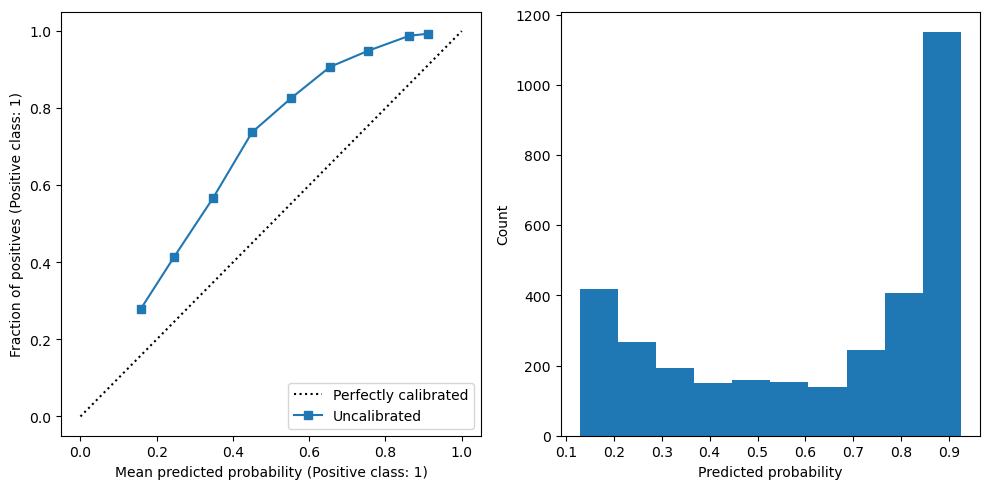

Brier score: 0.12962815527498703


In [7]:
#test calibration
display_calibration(final_model, df_test, features, "Uncalibrated")

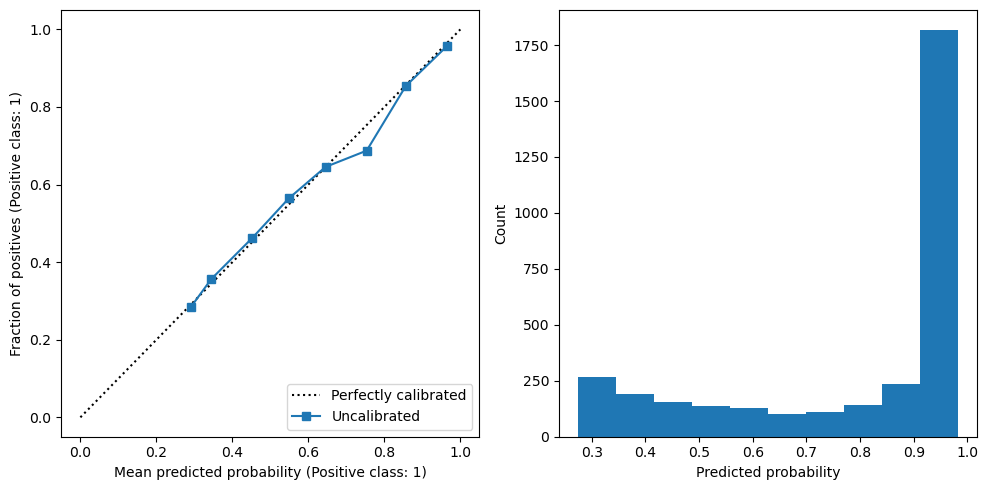

Brier score: 0.11380579305024069


In [9]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

df_tt, df_cal = train_test_split(df_train, test_size=0.2, shuffle=True, random_state=5, stratify=df_train.IN_LEAGUE_NEXT)

model = Pipeline([('smote', SMOTE(random_state=509)),
                  ('xgb', XGBClassifier(n_estimators=400, learning_rate=0.005, random_state=206))])

model.fit(df_tt[features], df_tt.IN_LEAGUE_NEXT)

final_model_cal = CalibratedClassifierCV(model, cv="prefit")
final_model_cal.fit(df_cal[features], df_cal.IN_LEAGUE_NEXT)

display_calibration(final_model_cal, df_test, features, "Uncalibrated")

## Conclusions

Our final model demonstrated strong performance in predicting whether NBA players would remain in the league. On the test set, it achieved a **balanced accuracy of 80.82%**, indicating robust performance across both classes. Notably, the model achieved a **precision of 94.71%**, reflecting high confidence in predicting players who stayed, and a **recall of 77.85%**, ensuring most players who stayed were correctly identified. Its **specificity of 83.79%** further highlights its ability to correctly identify players who left. While the **negative predictive value (NPV) of 50.08%** appears lower, this is expected given the model's prioritization of minimizing false positives (high precision) and achieving balanced accuracy (strong recall and specificity). Incorporating additional factors such as G-League data, contract terms, and injuries could likely improve the NPV.

| Model | Balanced Accuracy | Precision | Recall (sensitivity) | NPV | Specificity |
| --- | --- | --- | --- | --- | --- |
| Basline (always predicts 1) | 0.5000 | 0.7876 | 1.000 | 0.0000 | 0.0000 |
| XGBoost Classifier w/ SMOTE | 0.8082 | 0.9471 | 0.7785 | 0.5008 | 0.8379 |

To help visualize our results, let's take a random sample of 50 players from the 2022-2023 season and look at our predictions. The plot below shows the predicted probabilities of these players staying in the league; the red dashed line marks the decision threshold of 0.5, and the color of a bar indicates whether the prediction was correct (blue) or incorrect (orange).

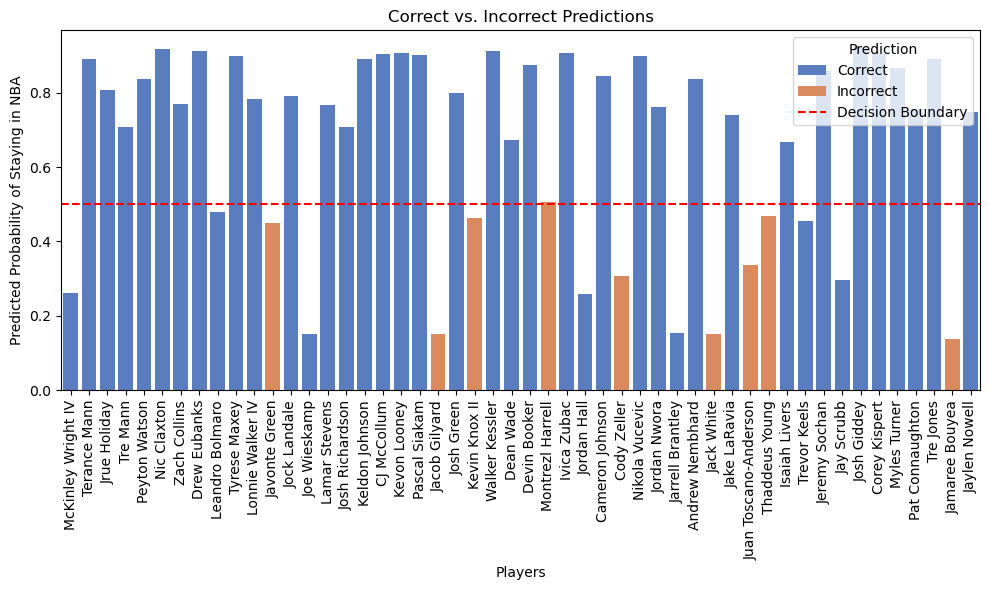

In [110]:
# get data for 2022-23 season
df_2022 = df_test.loc[df_test['SEASON_START']==2022].copy()

# create columns from predict and predict_proba
df_2022['PREDICT'] = final_model.predict(df_2022[features])
df_2022['PREDICT_PROBA'] = final_model.predict_proba(df_2022[features])[:,1]

# take a sample of 50 players
df = df_2022.sample(50).copy()

# create column indicating whether prediction was correct
df['CORRECT'] = (df['PREDICT'] == df['IN_LEAGUE_NEXT'])
df['CORRECT'] = df['CORRECT'].map({True: 'Correct', False: 'Incorrect'})

# plot predict_proba and show correct vs. incorrect predictions
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='NAME', y='PREDICT_PROBA', hue='CORRECT', hue_order=['Correct', 'Incorrect'], palette='muted')
plt.axhline(0.5, color='red', linestyle='--', label='Decision Threshold')
plt.title('Correct vs. Incorrect Predictions for 2022-2023')
plt.ylabel('Predicted Probability of Staying in NBA')
plt.xlabel('Players')
plt.xticks(rotation=90, fontsize=10)
plt.legend(title='Prediction', loc='upper right')
plt.tight_layout()
plt.show()

We note the following observations:
* All but one of the above players who were predicted to stay in the NBA did in fact stay, illustrating the high precision. The only false positive listed above was Motrezl Harrell, who missed the entire 2023-24 season due to an injury but returned for the 2024-25 season.

* Of the 8 false negatives shown (i.e., players who were predicted to leave but stayed), 6 of them have since been in and out of the G-league, indicating that our model has properly identified them as "fringe NBA players" who are quite likely to leave the NBA within the next few seasons.